# Моделирование кривой RHOB по данным GR, TRNP, DT, LIT, Stratigraphy для межсолевых отложений С-Домановичского месторождения

В старом фонде множество скважин, в которых не выполнялся RHOB. А он необходим для расчета физико-механических свойств, построения компонентной модели и т.д. Требуется обучить модель для расчета RHOB по данным GR, TRNP, DT, LIT, Stratigraphy, чтобы в дальнейшем по старому фонду скважин определить физико-механические свойства и другие параметры пород.<br>

Интервал исследований - межсолевые отложения (карбонатный разрез).<br>

###  Описание данных
<b> <i> Признаки: </i> </b> <br>
<b>Well </b> - номер скважины; <br>
<b>Depth </b> - глубина по стволу; <br>
<b>GR </b> - гамма-каротаж (ГК); <br>
<b>TRNP </b> - нейтронная пористость (ННКт/НГК); <br>
<b>DT </b> - акустический каротаж (АК); <br>
<b>LIT </b> - литологический фактор, расчетный коэффициент по данным TRNP и DT; <br>
<b>Stratigraphy </b> - стратиграфия. <br>

<b> <i> Целевой признак: </i> </b> <br>
<b>RHOB </b> - гамма-гамма плотностной каротаж (ГГП) (объемная плотность горных пород). <br>

# Оглавление
1. [Загрузка данных и изучение общей информации](#step1)
2. [Подготовка данных](#step2)
    * [Обработка пропусков](#step2_1)
    * [Исследование каротажных кривых](#step2_2)
    * [Разделение скважин на обучающую и тестовую выборки](#step2_3)
3. [Подбор модели](#step3)
4. [Тестирование модели](#step4)
5. [Выгрузка данных](#step5)
6. [Расчет модельных кривых на скважинах, в которых нет целевой кривой](#step6)

<div align='justify'> <i> Загружаем необходимые библиотеки и настраиваем Jupyter.

In [1]:
import math
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import catboost

from platform import python_version
from datetime import datetime

from IPython.display import display
import warnings
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib

<div align='justify'> <i> Информация о версиях используемых библиотек.

In [2]:
current_date = datetime.now().strftime("%Y.%m.%d")
print(f'Date: {current_date}')
print(f'Python version: {python_version()}')
print (f'Pandas version: {pd.__version__}')
print (f'Seaborn version: {sns.__version__}')
print (f'Numpy version: {np.__version__}')
print (f'Scipy version: {scipy.__version__}')
print (f'Sklearn version: {sklearn.__version__}')
print (f'CatBoost version: {catboost.__version__}')

Date: 2020.09.22
Python version: 3.7.6
Pandas version: 0.25.1
Seaborn version: 0.9.0
Numpy version: 1.19.0
Scipy version: 1.4.1
Sklearn version: 0.21.2
CatBoost version: 0.20.2


<div align="justify"> <i> Задаем константы и пишем функции, которые будем использовать многократно на протяжении всего проекта.

In [3]:
# начальное состояние для моделей
RANDOM_STATE = 12345

# цвета и палетка для графиков
COLOR = '#a52a2a'
COLOR_LINE = '#e29072'
PALETTE='rocket'

# функция расчета интервала вывода для гистограмм
# column - колонка с набором данных
# coeff - коэффициент при интерквартильном размахе
def get_range(column, coeff):
    iqr = column.quantile(0.75)-column.quantile(0.25)
    low = column.quantile(0.25)-coeff*iqr
    high = column.quantile(0.75)+coeff*iqr
    interval = (low, high)
    return interval
    
# строим график метрики
def show_metric_plot(x, metrics, x_label, y_label):
    plt.figure()
    plt.plot(x, metrics, color=COLOR)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(y_label)
    
    plt.show()

# cчитаем метрики для моделей поскважинно
# well_list - массив данных
# column_well - колонка с номерами скважин
# parametr_true - целевой признак
# parametr_model - предсказания по модели
def get_metrics_wells(well_list, column_well, parametr_true, parametr_model):
    wells_metrics = pd.DataFrame(data=well_list[column_well].unique(), columns=[column_well])
    
    wells_metrics['COR'] = np.nan
    wells_metrics['RMSE'] = np.nan
    wells_metrics['R2'] = np.nan
    
    for well in wells_metrics[column_well].unique():
    
        rmse = mean_squared_error(well_list[well_list[column_well]==well][parametr_true], well_list[well_list[column_well]==well][parametr_model])**0.5
        r2 = r2_score(well_list[well_list[column_well]==well][parametr_true], well_list[well_list[column_well]==well][parametr_model])     
        corr = well_list[well_list[column_well]==well][[parametr_true, parametr_model]].corr()

        wells_metrics.loc[wells_metrics[column_well]==well, 'COR'] = corr[parametr_true][parametr_model]
        wells_metrics.loc[wells_metrics[column_well]==well, 'RMSE'] = rmse
        wells_metrics.loc[wells_metrics[column_well]==well, 'R2'] = r2
    
    # добавим средние значения по всем столбцам
    wells_metrics = wells_metrics.append(wells_metrics.mean(axis=0), ignore_index=True)
    wells_metrics.loc[len(wells_metrics)-1, column_well] = 'All'
    
    return wells_metrics


# функция сглаживания кривой поскважинно
# wells_data - массив данных
# column_well - колонка с номерами скважин
# parametr - кривая которую надо сгладить
def roll_by_wells(wells_data, column_well, parametr):
    wells_data_temp = wells_data[[column_well, parametr]].copy()
    wells_data_temp[f'{parametr}_roll'] = np.nan
        
    for well in wells_data_temp[column_well].unique():
        wells_data_temp.loc[wells_data_temp[column_well] == well, f'{parametr}_roll'] = wells_data_temp[parametr].rolling(window=3).mean().shift(-1)
        wells_data_temp.loc[wells_data_temp[f'{parametr}_roll'].isnull(), f'{parametr}_roll'] = wells_data_temp[wells_data_temp[f'{parametr}_roll'].isnull()][parametr]
    
    return wells_data_temp[f'{parametr}_roll']

# 1. Загрузка данных и изучение общей информации <a name="step1"></a>

<div align="justify"> <i> Загрузим данные по скважинам и изучим их.

In [4]:
wells = pd.read_csv('S-Domanovichskoe_mejsol.csv', sep=';')
display(wells.head())
display(wells.info())
display(wells.describe())

,Well,Depth,GR,DT,TRNP,RHOB,LIT,Stratigraphy
0,61g,2640.8,3.7449,223.9130,0.1480,2.682486,53.5930,D3zd(trm)
1,61g,2640.9,3.7015,187.9770,0.1475,2.643626,17.8270,D3zd(trm)
2,61g,2641.0,3.6582,170.2830,0.1448,2.617856,1.0510,D3zd(trm)
3,61g,2641.1,3.6200,170.8310,0.1443,2.608167,1.7690,D3zd(trm)
4,61g,2641.2,3.5818,171.6812,0.1485,2.608682,1.1912,D3zd(trm)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32952 entries, 0 to 32951
Data columns (total 8 columns):
Well            32952 non-null object
Depth           32952 non-null float64
GR              32952 non-null float64
DT              32952 non-null float64
TRNP            32952 non-null float64
RHOB            32952 non-null float64
LIT             32952 non-null float64
Stratigraphy    32952 non-null object
dtypes: float64(6), object(2)
memory usage: 2.0+ MB


None

,Depth,GR,DT,TRNP,RHOB,LIT
count,32952.000000,32952.000000,32952.000000,32952.000000,32952.000000,32952.000000
mean,2695.278223,4.112400,189.267092,0.127703,2.651929,25.847944
std,182.396290,2.625058,25.125451,0.050033,0.117715,18.548225
min,2352.900000,0.407600,146.103000,-0.033900,1.973500,-34.209000
25%,2541.200000,2.110300,168.888200,0.097500,2.605000,12.744908
50%,2683.950000,3.207800,181.982850,0.118300,2.667894,22.177700
75%,2817.725000,5.765025,207.782625,0.158600,2.723817,35.756400
max,3110.400000,14.095900,343.209300,0.346800,2.966900,131.681300


<div style="border:solid orange 2px; padding: 20px">
<b> Заполняем информацию по месторождению, кривым  и т.д.</b>

In [5]:
oilfield_name = 'S-Domanovichskoe'
deposits_name = 'mejsol'
logs = ['GR', 'DT', 'TRNP', 'RHOB', 'LIT']
logs_units = ['u.e', 'μs/m', 'dec', 'g/cm3', 'u.e']

In [6]:
display(f"Месторождение: {oilfield_name}")
display(f"Отложения: {deposits_name}")
display(f"Количество скважин: {len(wells['Well'].unique())}")
display(f"Номера скважин: {wells['Well'].unique()}")
display(f"Методы ГИС: {logs}")

'Месторождение: S-Domanovichskoe'

'Отложения: mejsol'

'Количество скважин: 12'

"Номера скважин: ['61g' '58r' '56g' '53s3' '51' '67g' '65g' '63g' '60g' '59r2' '59r' '53']"

"Методы ГИС: ['GR', 'DT', 'TRNP', 'RHOB', 'LIT']"

# 2. Подготовка данных <a name="step2"></a>

<div align="justify"> <i> Основная обработка данных (увязка, сшивка каротажных кривых и т.д.) выполняется в специализированном ПО "Прайм" и "PowerLog", предназначенном для обработки и интерпретации данных керна и ГИС.

## Обработка пропусков <a name="step2_1"></a>

<div align="justify"> <i> В столбцах с каротажными данными могут быть пропуски. Причины следующие: <br>
1. По некоторым методам ГИС нет информации на забое, из-за недохождения приборов; <br>
2. Часть данных отсутствует при выходе из-под башмака колонны (кривые обрезаются специально, т.к. колонна влияет на показания методов);<br>
3. Кривые обрезаются вручную, поэтому граница может плавать +/- 0.5 м по разным кривым. <br>
Проверим есть ли пропуски в этиъ данных.

In [7]:
(wells.shape[0] - wells.dropna().shape[0])/len(wells)

0.0

<div align="justify"> <i> Построим карту пропущенных значений.

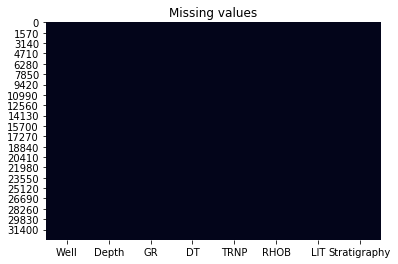

In [8]:
ax = sns.heatmap(wells.isnull(), cbar=False, cmap=PALETTE)
ax.set_title("Missing values")
plt.show()

<div align="justify"> <i> Пропущенных значений нет.

In [9]:
wells = wells.dropna()
wells.reset_index(drop=True, inplace=True)
wells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32952 entries, 0 to 32951
Data columns (total 8 columns):
Well            32952 non-null object
Depth           32952 non-null float64
GR              32952 non-null float64
DT              32952 non-null float64
TRNP            32952 non-null float64
RHOB            32952 non-null float64
LIT             32952 non-null float64
Stratigraphy    32952 non-null object
dtypes: float64(6), object(2)
memory usage: 2.0+ MB


## Исследование каротажных кривых <a name="step2_2"></a>

<div align="justify"> <i> Изучим распределения по каротажным кривым. <br>

'GR'

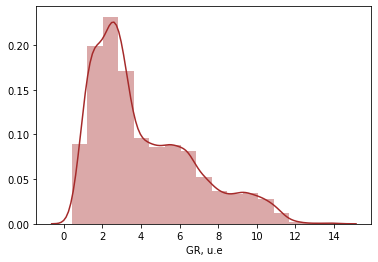

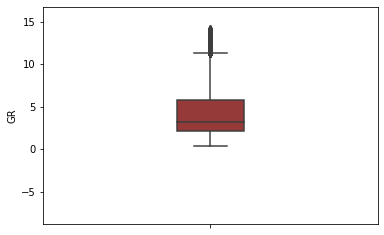

count    32952.000000
mean         4.112400
std          2.625058
min          0.407600
25%          2.110300
50%          3.207800
75%          5.765025
max         14.095900
Name: GR, dtype: float64

'DT'

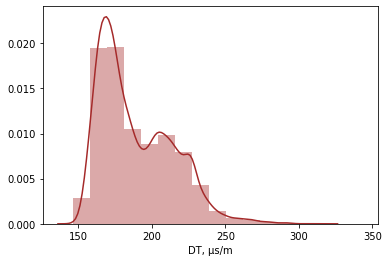

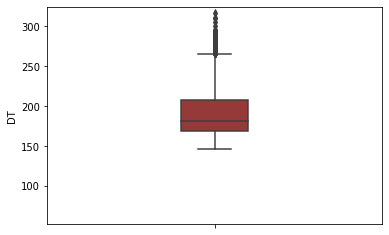

count    32952.000000
mean       189.267092
std         25.125451
min        146.103000
25%        168.888200
50%        181.982850
75%        207.782625
max        343.209300
Name: DT, dtype: float64

'TRNP'

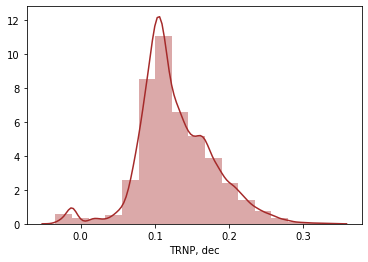

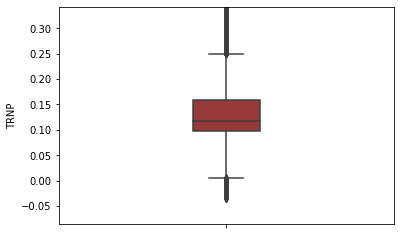

count    32952.000000
mean         0.127703
std          0.050033
min         -0.033900
25%          0.097500
50%          0.118300
75%          0.158600
max          0.346800
Name: TRNP, dtype: float64

'RHOB'

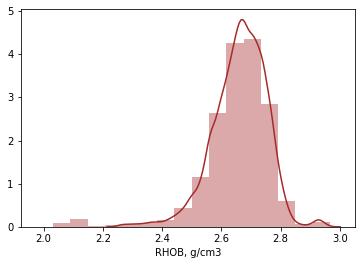

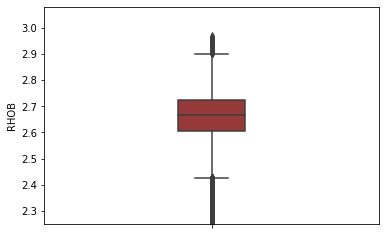

count    32952.000000
mean         2.651929
std          0.117715
min          1.973500
25%          2.605000
50%          2.667894
75%          2.723817
max          2.966900
Name: RHOB, dtype: float64

'LIT'

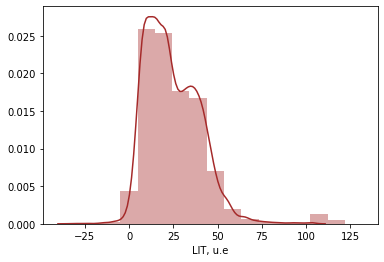

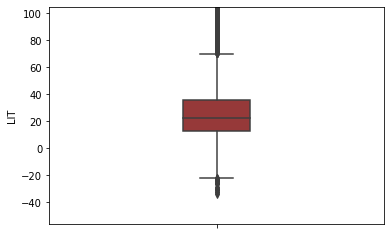

count    32952.000000
mean        25.847944
std         18.548225
min        -34.209000
25%         12.744908
50%         22.177700
75%         35.756400
max        131.681300
Name: LIT, dtype: float64

In [10]:
for log, unit in zip(logs, logs_units):
    display(log)
    
    wells_range = get_range(wells[log], 3)
    
    ax = sns.distplot(wells[log],
                      bins = np.histogram_bin_edges(wells[log], bins='sturges'),
                      kde_kws={'clip':wells_range, 'color':COLOR}, hist_kws={'range':wells_range, 'color':COLOR})
    
    ax.set(xlabel=f'{log}, {unit}')
    plt.show()  
    
    ax = sns.boxplot(y=wells[log], width=0.2, color=COLOR)
    ax.set(ylim=get_range(wells[log], 3))
    plt.show()
    
    display(wells[log].describe())
    display()

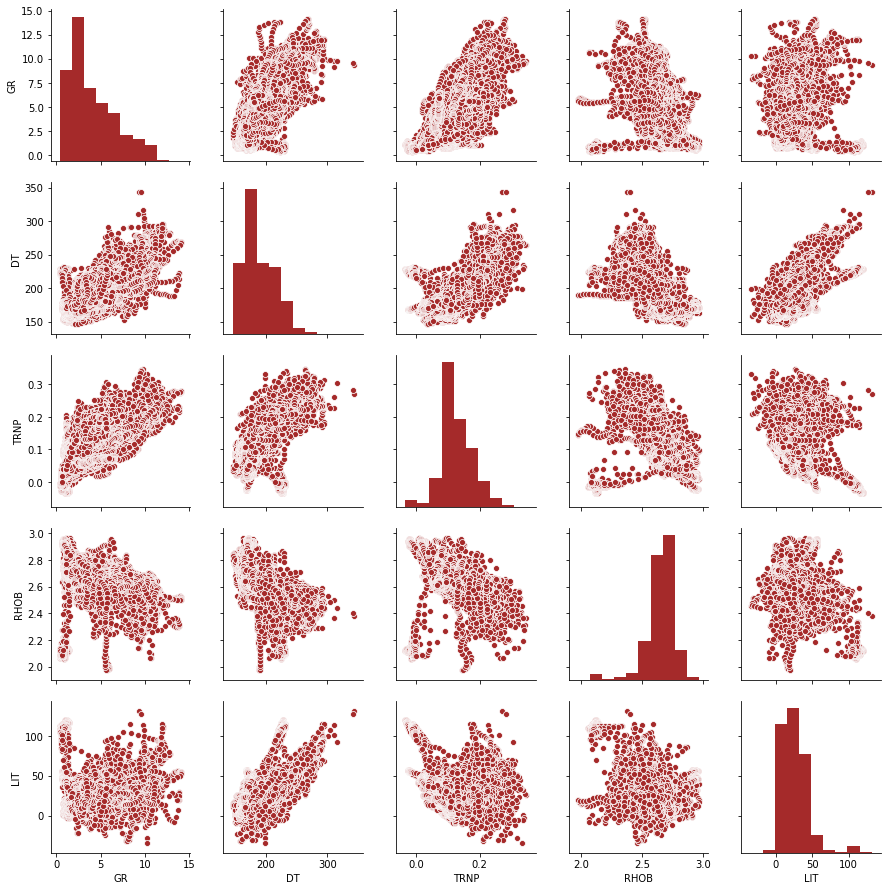

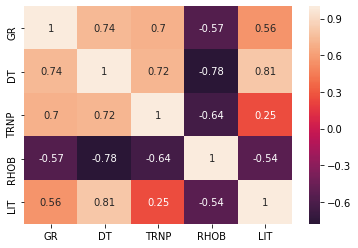

In [11]:
sns.pairplot(wells[logs], plot_kws=dict(color=COLOR), diag_kws=dict(color=COLOR))
plt.show()
    
corr = wells[logs].corr(method='spearman')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=PALETTE, center=0, annot=True)
plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. Распределение каротажных данных действительно характерно для карбонатного разреза. <br>
2. В разрезе присутствуют соли (отрицательные TRNP, близкие к нулю GR, RHOB~2-2.2 г/см3) и ангидриды (RHOB~2.9-3.0 г/см3) с характеримными для них значениями кривых, выпадающих из общих разпределений для доломита, известняка и глин.<br>
3. Аномальных значений нет. <br>
4. У целевого признака RHOB достаточно высокая корреляция со всеми кривыми.

## Разделение скважин на обучающую и тестовую выборки <a name="step2_3"></a>

In [12]:
display(wells['Well'].unique())

array(['61g', '58r', '56g', '53s3', '51', '67g', '65g', '63g', '60g',
       '59r2', '59r', '53'], dtype=object)

<div align="justify"> <i> В обучающую и тестовую выборки берут скважины с каротажными данными, качество и достоверность которых не вызывают сомнения. Также, которые наиболее полно освещены геолого-геофизическими матерьялами (керном испытаниями и т.д.).<br>
Скважины должны быть равномерно распределены по площади месторождения и охватывать наиболее полно целевой разрез. <br>

<div style="border:solid orange 2px; padding: 20px">
<b> Указываем какие скважины входят в тестовую выборку.</b>

In [13]:
wells_test_name = ['67g', '65g', '63g', '60g', '59r2', '59r', '53']

In [14]:
wells_name = list(wells['Well'].unique())
wells_train_name = list(set(wells_name)-set(wells_test_name))

print(f'All wells = {wells_name}\nNumber of all wells = {len(wells_name)}\n')
print(f'Train wells = {wells_train_name}\nNumber of train wells = {len(wells_train_name)}\n')
print(f'Test wells = {wells_test_name}\nNumber of test wells = {len(wells_test_name)}\n')

All wells = ['61g', '58r', '56g', '53s3', '51', '67g', '65g', '63g', '60g', '59r2', '59r', '53']
Number of all wells = 12

Train wells = ['56g', '61g', '51', '53s3', '58r']
Number of train wells = 5

Test wells = ['67g', '65g', '63g', '60g', '59r2', '59r', '53']
Number of test wells = 7



<div align="justify"> <i> Посмотрим распределения кривых ГИС по каждой скважине.

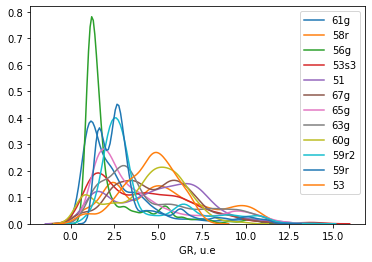

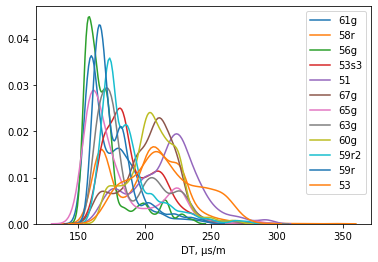

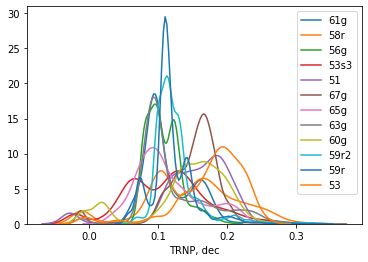

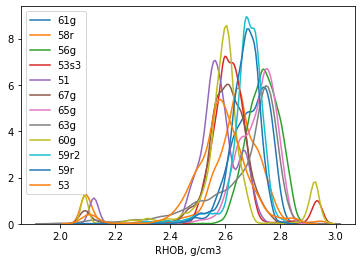

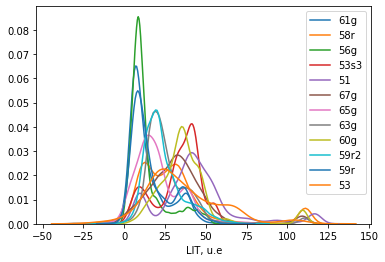

In [15]:
for log, unit in zip(logs, logs_units):
    for name in wells_name:
        wells_temp = wells[wells['Well']==name]
        
        ax = sns.distplot(wells_temp[log],
                          hist = False,
                          bins=np.histogram_bin_edges(wells_temp[log], bins='sturges'),
                          label=name)
        
        ax.set(xlabel=f'{log}, {unit}')
    plt.show()

<div align="justify"> <i> Сравним распределения кривых на обучающей и тестовой выборках.

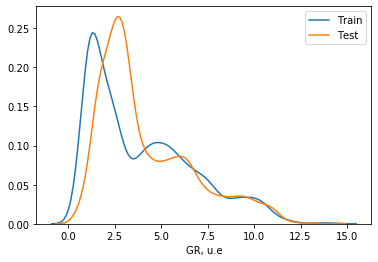

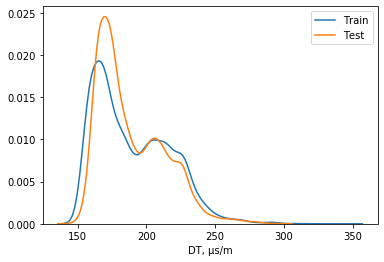

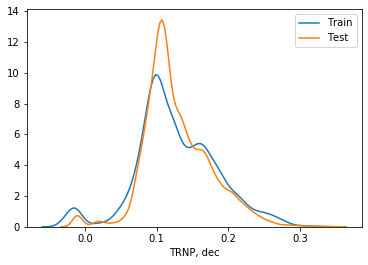

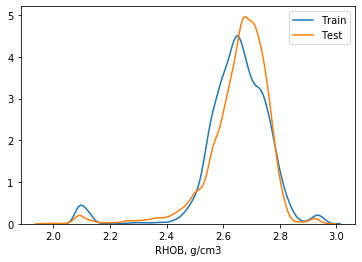

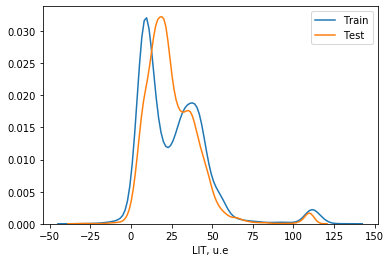

In [16]:
for log, unit in zip(logs, logs_units):
    for well_names, sampling_name in zip([wells_train_name, wells_test_name], ['Train', 'Test']):
        wells_temp = wells[wells['Well'].isin(well_names)]
        
        ax = sns.distplot(wells_temp[log],
                          hist = False,
                          bins=np.histogram_bin_edges(wells_temp[log], bins='sturges'),
                          label=sampling_name)
        
        ax.set(xlabel=f'{log}, {unit}')
    plt.show()

<div align="justify"> <i> Обучающая выборка скважин.

In [17]:
wells_train = wells[wells['Well'].isin(wells_train_name)]
wells_train.reset_index(drop=True, inplace=True)
display(f"Train wells = {wells_train['Well'].unique()}\nNumber of train wells = {len(wells_train['Well'].unique())}\n")

"Train wells = ['61g' '58r' '56g' '53s3' '51']\nNumber of train wells = 5\n"

<div align="justify"> <i> Тестовая группа скважин.

In [18]:
wells_test = wells[wells['Well'].isin(wells_test_name)]
wells_test.reset_index(drop=True, inplace=True)
display(f"Test wells = {wells_test['Well'].unique()}\nNumber of test wells = {len(wells_test['Well'].unique())}\n")

"Test wells = ['67g' '65g' '63g' '60g' '59r2' '59r' '53']\nNumber of test wells = 7\n"

In [19]:
display(f'Number of samples:\ntraining set - {len(wells_train)/len(wells)*100:.2f} %,\ntest set - {len(wells_test)/len(wells)*100:.2f} %.')

'Number of samples:\ntraining set - 31.91 %,\ntest set - 68.09 %.'

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. Количество точек записи в обучащей и тестовой выборках соотносятся близко к рекомендованным 2:1. <br>
2. Распределения величин в обучащей и тестовой выборках накладываются друг на друга.<br>
3. Разделение на обучающую и тестовую выборку выполнено верно.

<div style="border:solid orange 2px; padding: 20px">
<b> Указываем целевой признак, название модельной и сглаженной модельной кривых.</b>

In [20]:
target_log = 'RHOB'
model_log = f'{target_log}_model'
model_log_roll = f'{model_log}_roll'

<div align="justify"> <i> Для каждой группы скважин создадим features и target. Для модели будем использовать все признаки, кроме 'Well', 'Depth'. <br>

In [21]:
features_train = wells_train.drop(['Well', 'Depth', target_log], axis=1)
target_train = wells_train[target_log]

features_test = wells_test.drop(['Well', 'Depth', target_log], axis=1)
target_test = wells_test[target_log]

features = wells.drop(['Well', 'Depth', target_log], axis=1)
target = wells[target_log]

for features_, target_ in zip([features_train, features_test, features],
                              [target_train, target_test, target]):

    display(features_.shape)
    display(target_.shape)
    display()

(10514, 5)

(10514,)

(22438, 5)

(22438,)

(32952, 5)

(32952,)

# 3. Подбор модели <a name="step3"></a>

<div align='justify'> <i> Для выполнения поставленной задачи будем использовать библиотеку CatBoost.

In [22]:
cat_features = features_train.columns[features_train.dtypes == 'object']

<div align='justify'> <i> Подбираем оптимальные параметры.

In [23]:
"""
model = CatBoostRegressor(random_state=RANDOM_STATE)
model_params = {'iterations':[100, 200, 300, 400],
                'depth':[2, 4, 6, 8],
                'learning_rate':[0.03, 0.08, 0.12]}
grid = GridSearchCV(model, model_params , cv=5, n_jobs=-1, verbose=True)
"""

"\nmodel = CatBoostRegressor(random_state=RANDOM_STATE)\nmodel_params = {'iterations':[100, 200, 300, 400],\n                'depth':[2, 4, 6, 8],\n                'learning_rate':[0.03, 0.08, 0.12]}\ngrid = GridSearchCV(model, model_params , cv=5, n_jobs=-1, verbose=True)\n"

In [24]:
"""
grid.fit(features_train, target_train, cat_features=cat_features)
"""

'\ngrid.fit(features_train, target_train, cat_features=cat_features)\n'

In [25]:
"""
print(grid.best_params_)
print(grid.best_score_)
"""

'\nprint(grid.best_params_)\nprint(grid.best_score_)\n'

<div align='justify'> <i> Посмотрим метрики подобранной модели на обучающей выборке.

In [26]:
model_optimus = CatBoostRegressor(random_state=RANDOM_STATE, iterations = 300,  depth=4, learning_rate=0.12)
model_optimus.fit(features_train, target_train, cat_features=cat_features)

predictions_train_model_optimus = model_optimus.predict(features_train)
print(f'RMSE = {mean_squared_error(target_train, predictions_train_model_optimus)**0.5}')
print(f'R2 = {r2_score(target_train, predictions_train_model_optimus)}')

0:	learn: 0.1144900	total: 70.6ms	remaining: 21.1s
1:	learn: 0.1044493	total: 123ms	remaining: 18.4s
2:	learn: 0.0955117	total: 132ms	remaining: 13s
3:	learn: 0.0879237	total: 224ms	remaining: 16.6s
4:	learn: 0.0814134	total: 321ms	remaining: 19s
5:	learn: 0.0758416	total: 330ms	remaining: 16.1s
6:	learn: 0.0709497	total: 417ms	remaining: 17.4s
7:	learn: 0.0671359	total: 425ms	remaining: 15.5s
8:	learn: 0.0636328	total: 517ms	remaining: 16.7s
9:	learn: 0.0607463	total: 527ms	remaining: 15.3s
10:	learn: 0.0581087	total: 617ms	remaining: 16.2s
11:	learn: 0.0560354	total: 632ms	remaining: 15.2s
12:	learn: 0.0542619	total: 716ms	remaining: 15.8s
13:	learn: 0.0527504	total: 723ms	remaining: 14.8s
14:	learn: 0.0515837	total: 817ms	remaining: 15.5s
15:	learn: 0.0505978	total: 910ms	remaining: 16.1s
16:	learn: 0.0497867	total: 917ms	remaining: 15.3s
17:	learn: 0.0490312	total: 924ms	remaining: 14.5s
18:	learn: 0.0483488	total: 1.01s	remaining: 15s
19:	learn: 0.0476290	total: 1.11s	remaining: 1

<div align='justify'> <i> Посомтрим какие признаки вносят наибольший вклад в модель.

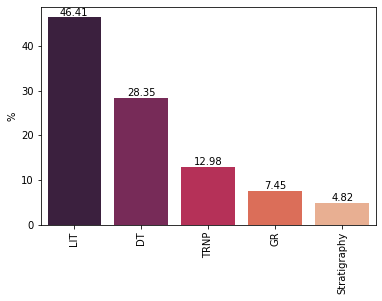

In [27]:
feature_importances = dict(zip(features_train.columns, model_optimus.feature_importances_))
feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

ax = sns.barplot(x=list(feature_importances.keys()), y=list(feature_importances.values()), palette=PALETTE)
ax.set(ylabel='%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for patch in ax.patches:
    h = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., h, f"{h:.{2}f}", ha='center', va='bottom')

plt.show()

<div align='justify'> <i> Сделаем массив данных для сопоставления результатов моделирования на обучающей выборке поскважинно.

In [28]:
wells_train_model = wells_train.copy()
wells_train_model[model_log] = predictions_train_model_optimus
wells_train_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10514 entries, 0 to 10513
Data columns (total 9 columns):
Well            10514 non-null object
Depth           10514 non-null float64
GR              10514 non-null float64
DT              10514 non-null float64
TRNP            10514 non-null float64
RHOB            10514 non-null float64
LIT             10514 non-null float64
Stratigraphy    10514 non-null object
RHOB_model      10514 non-null float64
dtypes: float64(7), object(2)
memory usage: 739.4+ KB


<div align='justify'> <i> Кривые RHOB, получаемые по модели выходят иногда слишком дискретными. Чтобы привести их к единому вертикальному масштабу с другими кривыми, необходимо провести сглаживание (rolling). Выполним стандартное сглаживание для шага дискретизации в 0.1 м по среднему значению с окном шириной в три точки. <br>
Поскольу ширина окна сглаживания 3 точки, то в первых 2-х получается отсутствие данных. Присвоим этим точкам исходные значения.

In [29]:
wells_train_model[model_log_roll] = roll_by_wells(wells_train_model, 'Well', model_log)
wells_train_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10514 entries, 0 to 10513
Data columns (total 10 columns):
Well               10514 non-null object
Depth              10514 non-null float64
GR                 10514 non-null float64
DT                 10514 non-null float64
TRNP               10514 non-null float64
RHOB               10514 non-null float64
LIT                10514 non-null float64
Stratigraphy       10514 non-null object
RHOB_model         10514 non-null float64
RHOB_model_roll    10514 non-null float64
dtypes: float64(8), object(2)
memory usage: 821.5+ KB


<div align='justify'> <i> Рассчитаем RMSE, R2, Corr по каждой скважине для обучающей выборки.

In [30]:
wells_train_metric = get_metrics_wells(wells_train_model, 'Well', target_log, model_log_roll)
wells_train_metric.head(len(wells_train_metric))

,Well,COR,RMSE,R2
0,61g,0.894438,0.032007,0.796615
1,58r,0.973937,0.036625,0.946849
2,56g,0.882854,0.029767,0.716098
3,53s3,0.943275,0.032084,0.857214
4,51,0.969510,0.029485,0.935945
5,All,0.932803,0.031993,0.850544


<div align='justify'> <i> Сопоставим предсказания с реальными значениями поскважинно.

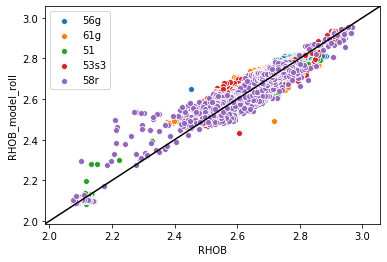

In [31]:
for well_name in wells_train_name:
    ax = sns.scatterplot(x=target_log, y=model_log_roll, data=wells_train_model[wells_train_model['Well']==well_name], label=well_name)

target_array = np.array(wells_train_model[target_log])
predictions_array = np.array(wells_train_model[model_log_roll])
all_points = np.vstack((target_array, predictions_array))
offset = (np.max(all_points) - np.min(all_points))/10
min_lim = np.min(all_points)-offset
max_lim = np.max(all_points)+offset
arrange_lim = [min_lim, max_lim]

ax.set(xlim=arrange_lim,  ylim=arrange_lim)

sns.lineplot(x=arrange_lim, y=arrange_lim, color='black')

plt.show()

<div align='justify'> <i> Сопоставим предсказания с реальными значениями на графике плотности.

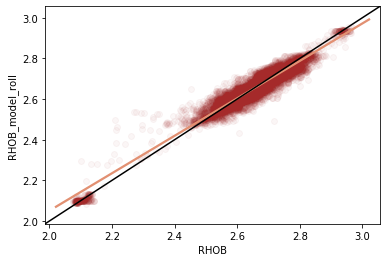

In [32]:
ax = sns.regplot(x=target_log, y=model_log_roll, data = wells_train_model, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)

target_array = np.array(wells_train_model[target_log])
predictions_array = np.array(wells_train_model[model_log_roll])
all_points = np.vstack((target_array, predictions_array))
offset = (np.max(all_points) - np.min(all_points))/10
min_lim = np.min(all_points)-offset
max_lim = np.max(all_points)+offset
arrange_lim = [min_lim, max_lim]

ax.set(xlim=arrange_lim,  ylim=arrange_lim)

sns.lineplot(x=arrange_lim, y=arrange_lim, color='black')

plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. RMSE достаточно низкая, а COR и R2 высокие. <br>
2. В скважинах 56g и 61g R2 ниже 0.8, т.к. они горизонтальные. RHOB в таких скважин имеет значительные флуктуации. <br>
3. Скважины должны оцениватся визуально на планшетах в программах аналогичных "Прайм" и "PowerLog"!!! Только после этого принимается решение о качестве модели.<br>

# 4. Тестирование модели <a name="step4"></a>

<div align='justify'> <i>
Проверим модель на тестовой выборке c учетом найденных параметров.

In [33]:
predictions_test_model_optimus = model_optimus.predict(features_test)
display(f'RMSE = {mean_squared_error(target_test, predictions_test_model_optimus)**0.5}')
display(f'R2 = {r2_score(target_test, predictions_test_model_optimus)}')

'RMSE = 0.0632385513215106'

'R2 = 0.6887907177362663'

<div align='justify'> <i> Сделаем массив данных для сопоставления результатов моделирования на тестовой выборке поскважинно.

In [34]:
wells_test_model = wells_test.copy()
wells_test_model[model_log] = predictions_test_model_optimus
wells_test_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22438 entries, 0 to 22437
Data columns (total 9 columns):
Well            22438 non-null object
Depth           22438 non-null float64
GR              22438 non-null float64
DT              22438 non-null float64
TRNP            22438 non-null float64
RHOB            22438 non-null float64
LIT             22438 non-null float64
Stratigraphy    22438 non-null object
RHOB_model      22438 non-null float64
dtypes: float64(7), object(2)
memory usage: 1.5+ MB


<div align='justify'> <i> Кривая по модели случайного леса выходит слишком дискретной. Чтобы привести ее к единому вертикальному масштабу с другими кривыми, необходимо провести сглаживание. Выполним стандартное сглаживание для шага дискретизации в 0.1 м по среднему значению с окном шириной в три точки. <br>
Поскольу ширина окна сглаживания 3 точки, то в первых 2-х получается отсутствие данных. Присвоим этим точкам исходные значения.

In [35]:
wells_test_model[model_log_roll] = roll_by_wells(wells_test_model, 'Well', model_log)
wells_test_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22438 entries, 0 to 22437
Data columns (total 10 columns):
Well               22438 non-null object
Depth              22438 non-null float64
GR                 22438 non-null float64
DT                 22438 non-null float64
TRNP               22438 non-null float64
RHOB               22438 non-null float64
LIT                22438 non-null float64
Stratigraphy       22438 non-null object
RHOB_model         22438 non-null float64
RHOB_model_roll    22438 non-null float64
dtypes: float64(8), object(2)
memory usage: 1.7+ MB


<div align='justify'> <i> Рассчитаем RMSE, R2, Corr по каждой скважине для тестовой выборки.

In [36]:
wells_test_metric = get_metrics_wells(wells_test_model, 'Well', target_log, model_log_roll)
wells_test_metric.head(len(wells_test_metric))

,Well,COR,RMSE,R2
0,67g,0.897016,0.051313,0.786151
1,65g,0.804252,0.054488,0.294238
2,63g,0.799653,0.085367,0.635710
3,60g,0.883492,0.074961,0.770063
4,59r2,0.778905,0.041779,0.594398
5,59r,0.763193,0.040741,0.546971
6,53,0.732497,0.080552,0.526731
7,All,0.808430,0.061314,0.593466


<div align='justify'> <i> Сопоставим предсказания с реальными значениями поскважинно.

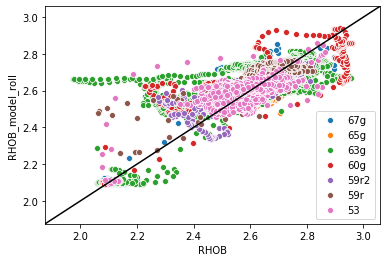

In [37]:
for well_name in wells_test_name:
    ax = sns.scatterplot(x=target_log, y=model_log_roll, data=wells_test_model[wells_test_model['Well']==well_name], label=well_name)

target_array = np.array(wells_test_model[target_log])
predictions_array = np.array(wells_test_model[model_log_roll])
all_points = np.vstack((target_array, predictions_array))
offset = (np.max(all_points) - np.min(all_points))/10
min_lim = np.min(all_points)-offset
max_lim = np.max(all_points)+offset
arrange_lim = [min_lim, max_lim]

ax.set(xlim=arrange_lim,  ylim=arrange_lim)

sns.lineplot(x=arrange_lim, y=arrange_lim, color='black')

plt.show()

<div align='justify'> <i> Сопоставим предсказания с реальными значениями на графике плотности.

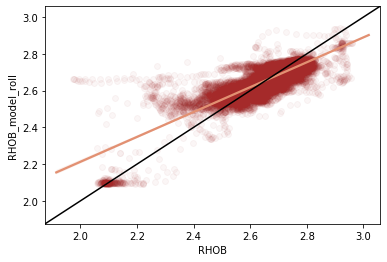

In [38]:
ax = sns.regplot(x=target_log, y=model_log_roll, data = wells_test_model, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)

target_array = np.array(wells_test_model[target_log])
predictions_array = np.array(wells_test_model[model_log_roll])
all_points = np.vstack((target_array, predictions_array))
offset = (np.max(all_points) - np.min(all_points))/10
min_lim = np.min(all_points)-offset
max_lim = np.max(all_points)+offset
arrange_lim = [min_lim, max_lim]

ax.set(xlim=arrange_lim,  ylim=arrange_lim)

sns.lineplot(x=arrange_lim, y=arrange_lim, color='black')

plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. После визуальной оценки полученных данных на планшетах в ПО "Прайм" можно сделать вывод, что модель работает достаточно хорошо. И данные на выходе получаются более достоверны и близкие к реальным кривым, чем по общепринятым формулам, которые использовались ранее при прогнозе RHOB. <br>
2. В тестовой выборке в основном горизонтальные скважины. RHOB в таких скважин имеет значительные флуктуации. Соответственно R2 низкие. <br>

# 5. Выгрузка данных <a name="step5"></a>

In [39]:
# wells_train_model.to_csv(f'{oilfield_name}_{deposits_name}_wells_train_model_curve_{current_date}.csv')
# wells_train_metric.to_csv(f'{oilfield_name}_{deposits_name}_wells_train_metric_{current_date}.csv')
# wells_test_model.to_csv(f'{oilfield_name}_{deposits_name}_wells_test_model_curve_{current_date}.csv')
# wells_test_metric.to_csv(f'{oilfield_name}_{deposits_name}_wells_test_metric_{current_date}.csv')
# joblib.dump(model_optimus, f'{oilfield_name}_{deposits_name}_{current_date}.sav')

# 6. Расчет модельных кривых на скважинах, в которых нет целевой кривой <a name="step6"></a>

In [40]:
wells_new = pd.read_csv('S-Domanovichskoe_mejsol_new.csv', sep=';')
display(wells_new.head())
display(wells_new.info())
wells_new.describe()

,Well,Depth,GR,DT,TRNP,LIT,Stratigraphy
0,67g,2434.3,0.49560,225.97110,-0.0132,110.45910,D3lb(zl)
1,67g,2434.4,0.52790,221.52750,-0.0130,105.94750,D3lb(zl)
2,67g,2434.5,0.52145,221.18680,-0.0130,105.60680,D3lb(zl)
3,67g,2434.6,0.51500,220.84610,-0.0130,105.26610,D3lb(zl)
4,67g,2434.7,0.51345,219.64485,-0.0130,104.06485,D3lb(zl)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36969 entries, 0 to 36968
Data columns (total 7 columns):
Well            36969 non-null object
Depth           36969 non-null float64
GR              36969 non-null float64
DT              36969 non-null float64
TRNP            36969 non-null float64
LIT             36969 non-null float64
Stratigraphy    36969 non-null object
dtypes: float64(5), object(2)
memory usage: 2.0+ MB


None

,Depth,GR,DT,TRNP,LIT
count,36969.000000,36969.000000,36969.000000,36969.000000,36969.000000
mean,2662.422827,4.013438,190.359932,0.127877,26.881841
std,213.396613,2.460373,23.795173,0.048047,17.986514
min,2282.900000,0.407600,146.103000,-0.041700,-32.434800
25%,2479.000000,2.127300,171.411347,0.098600,14.935597
50%,2623.800000,3.202200,183.990800,0.119300,24.282600
75%,2843.900000,5.638050,207.535400,0.160600,36.023800
max,3115.300000,13.843400,295.365600,0.346800,124.709400


<div style="border:solid orange 2px; padding: 20px">
<b> Указываем каротажные кривые по новым скважинам.</b>

In [41]:
logs_new = ['GR', 'DT', 'TRNP', 'LIT']
logs_units_new = ['u.e', 'μs/m', 'dec', 'u.e']

In [42]:
display(f"Месторождение: {oilfield_name}")
display(f"Отложения: {deposits_name}")
display(f"Количество скважин: {len(wells_new['Well'].unique())}")
display(f"Номера скважин: {wells_new['Well'].unique()}")

'Месторождение: S-Domanovichskoe'

'Отложения: mejsol'

'Количество скважин: 12'

"Номера скважин: ['67g' '65g' '63g' '60g' '59r2' '59r' '53' '25' '30' '31' '32' '54n']"

<div align="justify"> <i> Проверим есть ли пропуски в данных.

In [43]:
(wells_new.shape[0] - wells_new.dropna().shape[0])/len(wells_new)

0.0

<div align="justify"> <i> Построим карту пропущенных значений.

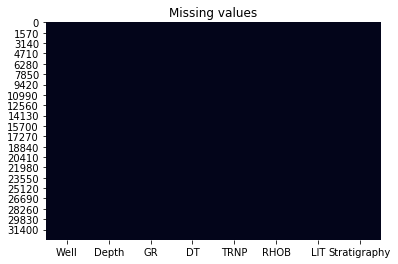

In [44]:
ax = sns.heatmap(wells.isnull(), cbar=False, cmap=PALETTE)
ax.set_title("Missing values")
plt.show()

<div align="justify"> <i> Пропущенных значений нет.

In [45]:
wells_new = wells_new.dropna()
wells_new.reset_index(drop=True, inplace=True)
wells_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36969 entries, 0 to 36968
Data columns (total 7 columns):
Well            36969 non-null object
Depth           36969 non-null float64
GR              36969 non-null float64
DT              36969 non-null float64
TRNP            36969 non-null float64
LIT             36969 non-null float64
Stratigraphy    36969 non-null object
dtypes: float64(5), object(2)
memory usage: 2.0+ MB


<div align="justify"> <i> Сравним распределения кривых на новых скважинах и использовавшихся для построения модели.

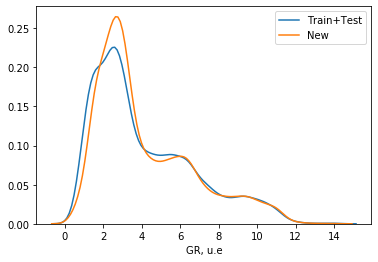

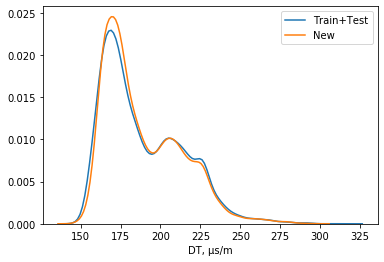

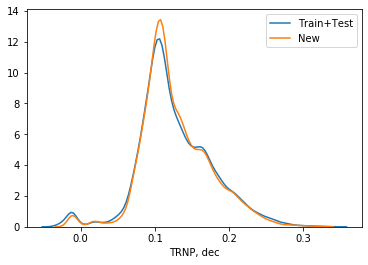

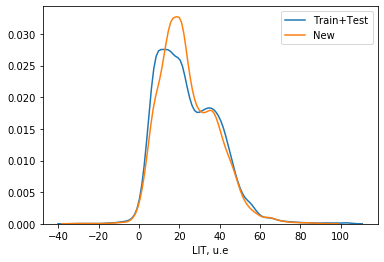

In [46]:
for log, unit in zip(logs_new, logs_units_new):
    for well_names, sampling_name in zip([wells['Well'].unique(), wells_new['Well'].unique()], ['Train+Test', 'New']):
        wells_temp = wells[wells['Well'].isin(well_names)]
        wells_range = get_range(wells_temp[log], 3)
        
        ax = sns.distplot(wells_temp[log],
                          hist = False,
                          bins=np.histogram_bin_edges(wells_temp[log], bins='sturges'),
                          kde_kws={'clip':wells_range},
                          label=sampling_name)
        
        ax.set(xlabel=f'{log}, {unit}')
    plt.show()

In [47]:
features_new = wells_new.drop(['Well', 'Depth'], axis=1)
features_new.head()

,GR,DT,TRNP,LIT,Stratigraphy
0,0.49560,225.97110,-0.0132,110.45910,D3lb(zl)
1,0.52790,221.52750,-0.0130,105.94750,D3lb(zl)
2,0.52145,221.18680,-0.0130,105.60680,D3lb(zl)
3,0.51500,220.84610,-0.0130,105.26610,D3lb(zl)
4,0.51345,219.64485,-0.0130,104.06485,D3lb(zl)


In [48]:
predictions_new = model_optimus.predict(features_new)
wells_new_model = wells_new.copy()
wells_new_model[model_log] = predictions_new
wells_new_model[model_log_roll] = roll_by_wells(wells_new_model, 'Well', model_log)
wells_new_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36969 entries, 0 to 36968
Data columns (total 9 columns):
Well               36969 non-null object
Depth              36969 non-null float64
GR                 36969 non-null float64
DT                 36969 non-null float64
TRNP               36969 non-null float64
LIT                36969 non-null float64
Stratigraphy       36969 non-null object
RHOB_model         36969 non-null float64
RHOB_model_roll    36969 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


<div align="justify"> <i> Выгружаем данные по скважинам, в которых нет реального RHOB.

In [49]:
# wells_new_model.to_csv(f'{oilfield_name}_{deposits_name}_wells_new_model_curve_{current_date}.csv')